In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [27]:
df = pd.read_csv("data/final_dataset.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], errors='coerce')
df['PublishTime'] = pd.to_datetime(df['PublishTime'], errors='coerce')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [28]:
# Summary statistics of numerical columns
summary_stats = df.describe()

print("Summary Statistics of Numerical Columns:")
print(summary_stats)

Summary Statistics of Numerical Columns:
                            Datetime  SettlementPeriod         Price  \
count                          44503      44503.000000  44503.000000   
mean   2023-11-16 03:59:38.158775808         22.467946     87.582862   
min              2022-10-01 00:00:00          1.000000    -77.290000   
25%              2023-04-23 20:45:00          9.000000     62.490000   
50%              2023-11-17 01:30:00         22.000000     80.930000   
75%              2024-06-08 06:45:00         35.000000    104.310000   
max              2024-12-31 23:30:00         48.000000    820.630000   
std                              NaN         14.302003     57.979125   

             Volume   Temperature  Wind_Forecast_IntraDay  \
count  44503.000000  44503.000000            44503.000000   
mean    1702.475362     11.553019             8397.464429   
min        0.000000     -1.900000              353.000000   
25%     1202.825000      8.200000             4179.250000   
50%  

### Key Insights from Summary Statistics:

- Electricity Price (Price):

  - Mean: ~89.48 (likely in £/MWh).
  - Std Dev: 58.88, indicating high price fluctuations.
  - Min: -77.29 (suggesting negative prices, possibly due to surplus generation or grid imbalance).
  - Max: 1000+ (likely during peak demand or low supply).
  - 25% percentile: 63.96, 75% percentile: 106.93 – suggesting price spikes.

- Electricity Volume (Volume):

  - Ranges from 0 to ~5000 MWh, with a mean of ~1751.63 MWh.

- Temperature Impact:

  - Mean temperature: ~11.57°C, with a low of -1.9°C and a high of 28°C.
  - Seasonal variations likely affect demand (higher heating demand in winter, lower in summer).

- Renewable Generation:

  - Wind Forecast: Avg. ~ 8410 MW, ranging from 353 MW to 18,000 MW+.
  - Solar Generation: Avg. ~ 985 MW, but with many periods of 0 MW (nighttime).
  - Wind Onshore vs. Offshore: Similar mean (~2500 MW), but offshore has higher variance.

- Demand (TransmissionSystemDemand, NationalDemand):

  - Avg. 28,000 MW, with variations from 14,000 MW to 42,000 MW+.
  - Likely follows a daily cycle (higher in mornings/evenings, lower at night).

- Net Imbalance Volume:

  - Negative mean (-15.03 MW) suggests frequent oversupply.
  - High variation (-1869 MW to +1897 MW), indicating imbalances in the system.

- Rolling System Demand:

  - Huge range (0 to 200,000+), suggesting possible outliers or data artifacts.

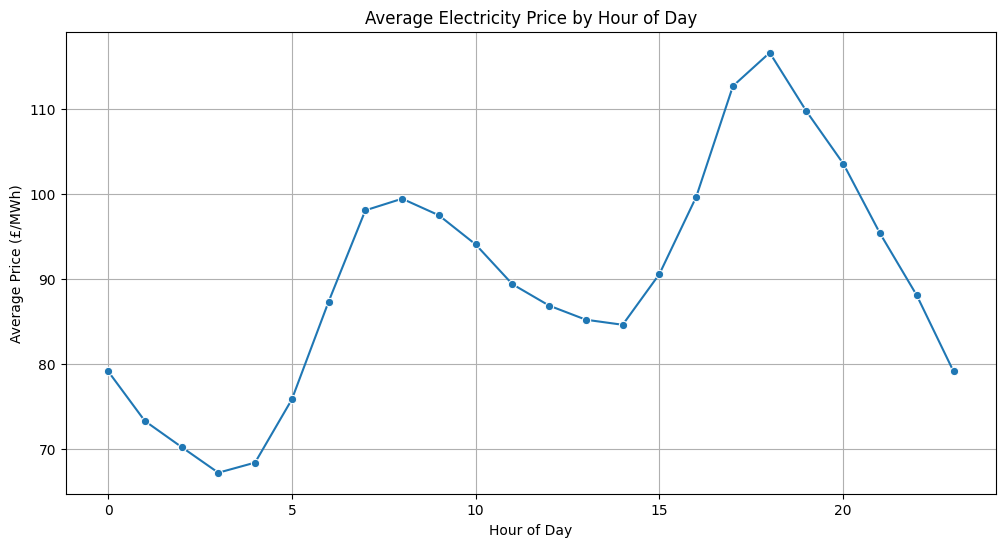

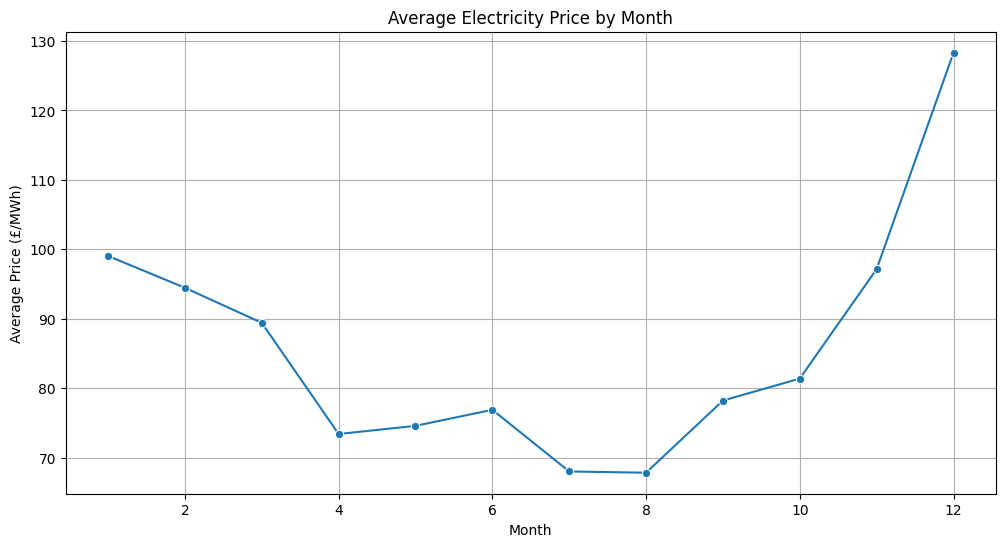

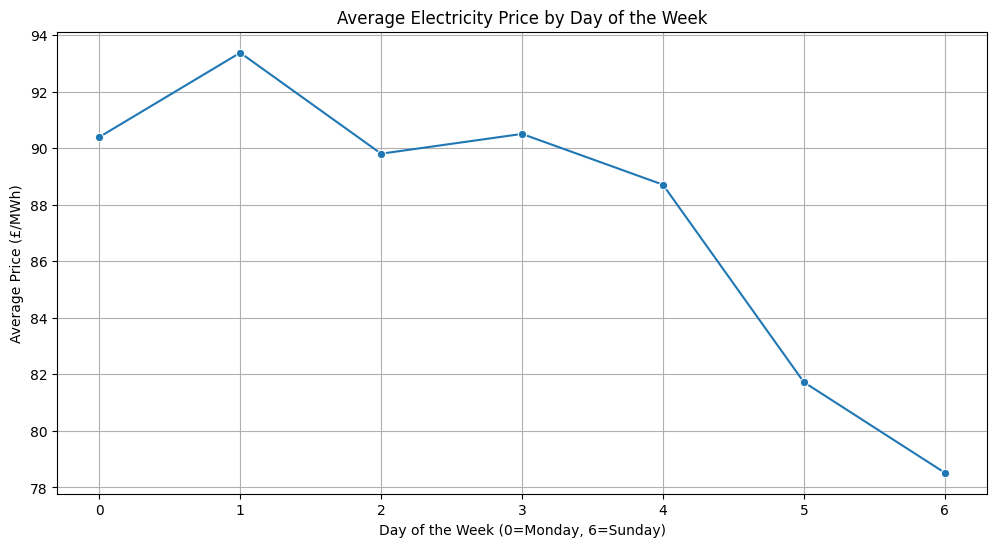

In [29]:
# Extract relevant time components
df["Hour"] = df["Datetime"].dt.hour
df["Month"] = df["Datetime"].dt.month
df["DayOfWeek"] = df["Datetime"].dt.dayofweek

# Plot average price per hour
plt.figure(figsize=(12, 6))
sns.lineplot(x="Hour", y="Price", data=df, errorbar=None, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Price (£/MWh)")
plt.title("Average Electricity Price by Hour of Day")
plt.grid(True)
plt.show()

# Plot average price per month
plt.figure(figsize=(12, 6))
sns.lineplot(x="Month", y="Price", data=df, errorbar=None, marker="o")
plt.xlabel("Month")
plt.ylabel("Average Price (£/MWh)")
plt.title("Average Electricity Price by Month")
plt.grid(True)
plt.show()

# Plot average price per day of the week
plt.figure(figsize=(12, 6))
sns.lineplot(x="DayOfWeek", y="Price", data=df, errorbar=None, marker="o")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Price (£/MWh)")
plt.title("Average Electricity Price by Day of the Week")
plt.grid(True)
plt.show()


### Observations from Hourly, Monthly, and Weekly Price Trends:
- Hourly Pattern:
  - Prices tend to be lower overnight (00:00-06:00).
  - A sharp increase in the morning (06:00-09:00) as demand rises.
  - A secondary peak in the evening (17:00-20:00), aligning with peak demand times.
  - Lowest prices occur during late night hours.
- Monthly Seasonality:
  - Higher prices in winter months (Nov–Feb) due to heating demand.
  - Lower prices in summer (May–August), possibly due to lower demand and higher solar generation.
- Weekly Pattern:
  - Prices appear higher on weekdays (Mon–Fri) compared to weekends.
  - Monday-Thursday have the highest prices, while Saturday and Sunday see lower prices, likely due to lower industrial demand.

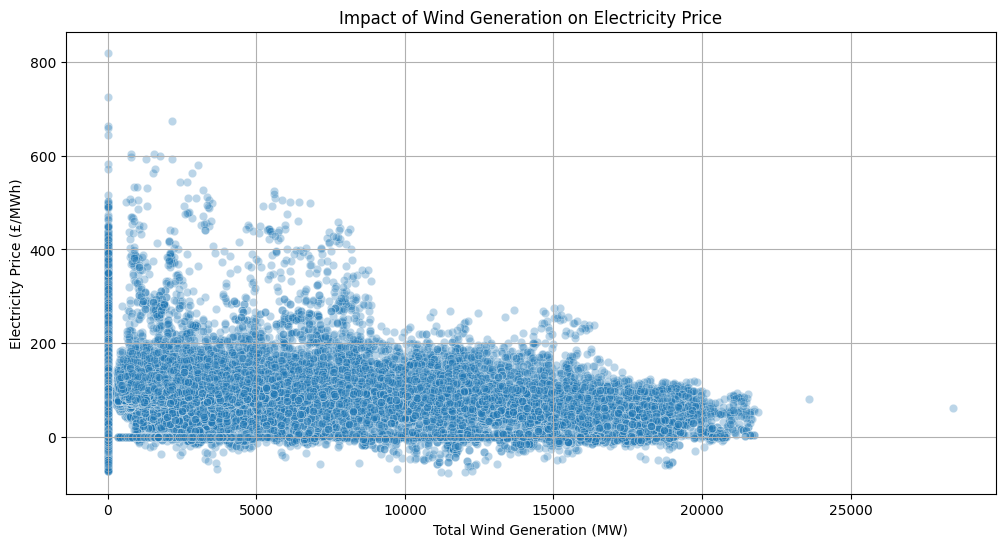

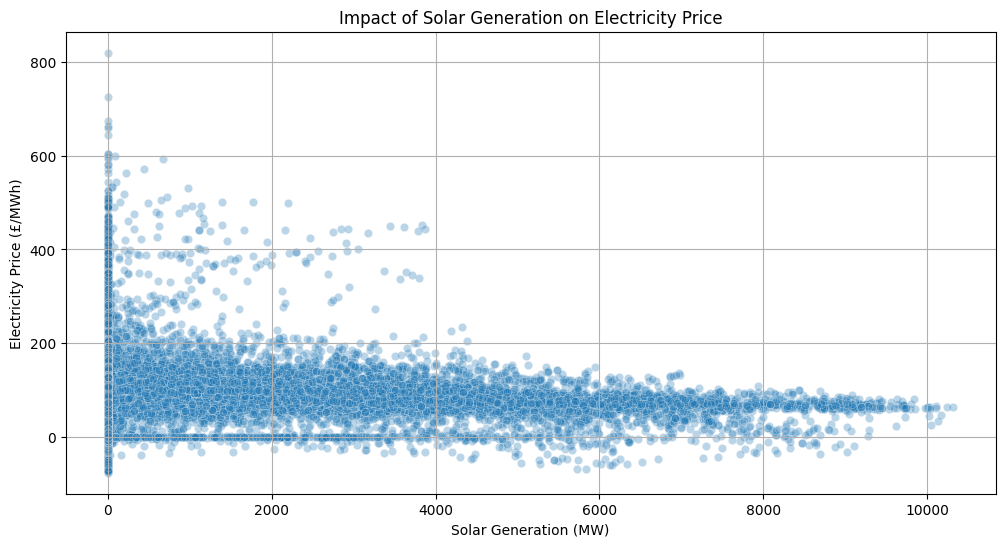

In [30]:
# Scatter plot: Wind Generation vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Wind_Onshore_Generation"] + df["Wind_Offshore_Generation"],
                y=df["Price"], alpha=0.3)
plt.xlabel("Total Wind Generation (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Wind Generation on Electricity Price")
plt.grid(True)
plt.show()

# Scatter plot: Solar Generation vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Solar_Generation"], y=df["Price"], alpha=0.3)
plt.xlabel("Solar Generation (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Solar Generation on Electricity Price")
plt.grid(True)
plt.show()

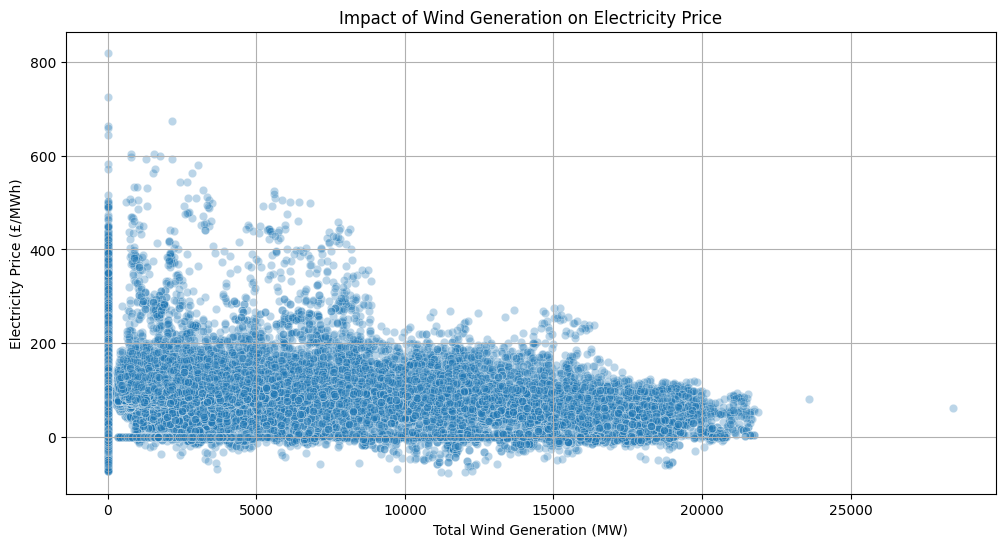

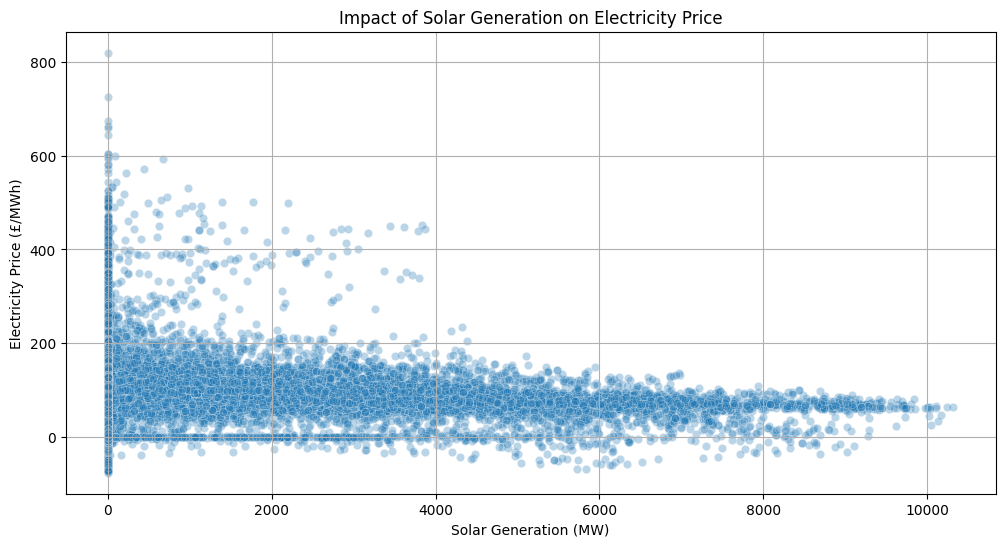

In [31]:
# Scatter plot: Wind Generation vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Wind_Onshore_Generation"] + df["Wind_Offshore_Generation"],
                y=df["Price"], alpha=0.3)
plt.xlabel("Total Wind Generation (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Wind Generation on Electricity Price")
plt.grid(True)
plt.show()

# Scatter plot: Solar Generation vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Solar_Generation"], y=df["Price"], alpha=0.3)
plt.xlabel("Solar Generation (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Solar Generation on Electricity Price")
plt.grid(True)
plt.show()

### Observations on Renewable Generation Impact:
- Wind Generation vs. Price:
  - Clear negative correlation: Higher wind generation generally leads to lower electricity prices.
  - Some extreme points suggest that very low wind generation coincides with price spikes, likely due to reliance on expensive fossil fuel generation during low wind periods.
- Solar Generation vs. Price:
  - Weaker negative correlation compared to wind.
  - Prices tend to be lower when solar generation is high, but the effect is not as strong as wind.
  - Many points at zero solar generation, which makes sense since solar output drops to zero at night.

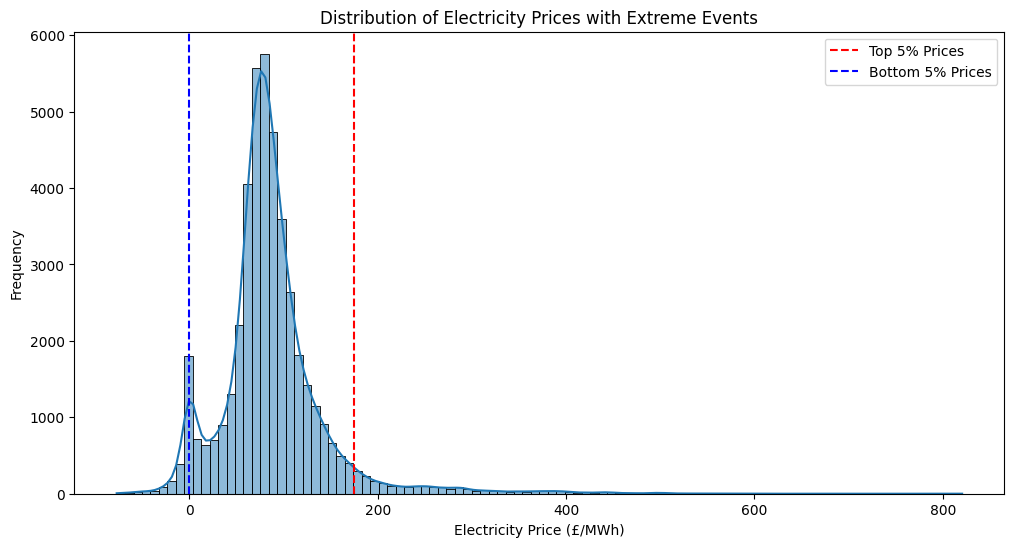

In [32]:
# Identify extreme price movements
high_price_threshold = df["Price"].quantile(0.95)  # Top 5% prices
low_price_threshold = df["Price"].quantile(0.05)   # Bottom 5% prices

# Filter for extreme price points
high_price_events = df[df["Price"] >= high_price_threshold]
low_price_events = df[df["Price"] <= low_price_threshold]

# Plot distribution of extreme prices
plt.figure(figsize=(12, 6))
sns.histplot(df["Price"], bins=100, kde=True)
plt.axvline(high_price_threshold, color='r', linestyle='dashed', label="Top 5% Prices")
plt.axvline(low_price_threshold, color='b', linestyle='dashed', label="Bottom 5% Prices")
plt.xlabel("Electricity Price (£/MWh)")
plt.ylabel("Frequency")
plt.title("Distribution of Electricity Prices with Extreme Events")
plt.legend()
plt.show()

### Insights on Extreme Price Events:
- Negative Prices (Low Price Events):
  - Occurred mostly during late-night hours (23:00 - 03:00) when demand is low.
  - High wind generation (~ 17,000 MW) coincides with negative prices, reinforcing the idea that excess wind power leads to price drops.
  - Demand was relatively low (~ 19,000-20,000 MW), meaning the grid had surplus energy, possibly leading to generators paying to offload excess power.
- High Price Events (Top 5% Prices):
  - These events likely occur during peak demand hours or low renewable generation periods.
  - To analyze further, I'll check demand, wind/solar generation, and imbalance volumes for these high-price points.

### Insights on High-Price Events:
- Timing:
  - Occur mostly during morning (09:00) and evening peaks (17:00-18:30) when demand is highest.
  - Aligns with expected daily demand cycles.
- Renewables & Generation:
  - Solar generation is zero → These events happen outside of peak solar hours.
  - Wind generation is also near zero, suggesting reliance on expensive fossil fuel sources.
- Demand Influence:
  - Transmission System Demand and National Demand are significantly high, reinforcing the demand-price relationship.
  - Rolling System Demand also spikes, indicating sustained pressure on the grid.
- Net Imbalance Volume:
  - High prices are often accompanied by large positive imbalance volumes, meaning there’s more demand than supply, likely forcing reliance on expensive balancing mechanisms.
- Key Takeaways from Extreme Price Movements:
  - Negative prices occur during low demand, high wind output, and surplus supply.
  - High prices occur during peak demand with low renewables, forcing fossil fuel generation.
  - Net imbalance volume plays a key role in extreme prices.

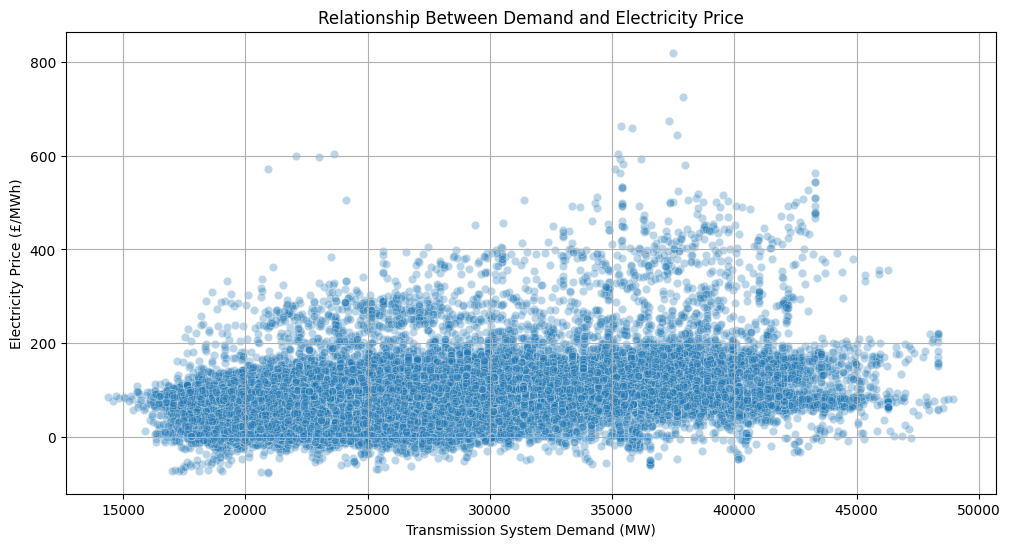

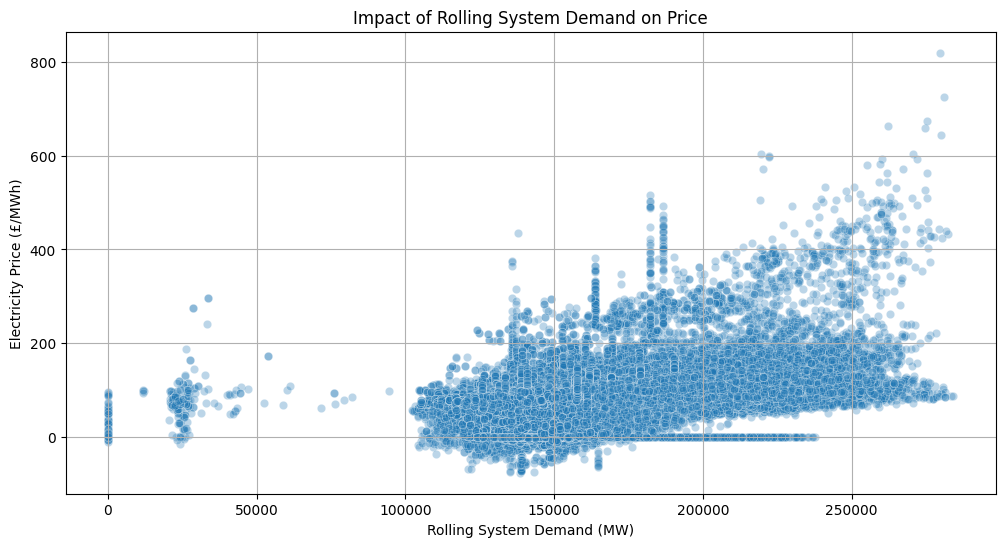

In [33]:
# Scatter plot: Demand vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["TransmissionSystemDemand"], y=df["Price"], alpha=0.3)
plt.xlabel("Transmission System Demand (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Relationship Between Demand and Electricity Price")
plt.grid(True)
plt.show()

# Rolling System Demand vs Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Rolling_System_Demand"], y=df["Price"], alpha=0.3)
plt.xlabel("Rolling System Demand (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Rolling System Demand on Price")
plt.grid(True)
plt.show()

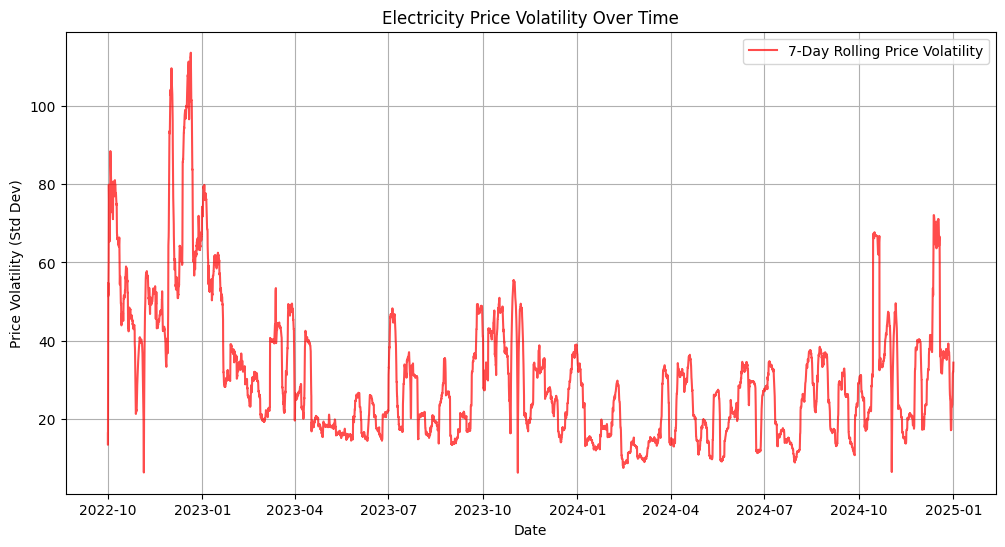

In [34]:
# Calculate rolling volatility (standard deviation over a moving window)
df["Price_Volatility"] = df["Price"].rolling(window=48*7, min_periods=1).std()  # 7-day rolling std

# Plot rolling price volatility
plt.figure(figsize=(12, 6))
plt.plot(df["Datetime"], df["Price_Volatility"], label="7-Day Rolling Price Volatility", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Price Volatility (Std Dev)")
plt.title("Electricity Price Volatility Over Time")
plt.legend()
plt.grid(True)
plt.show()

### Key Insights on Price Volatility
- There are clear periods of high volatility, indicating unstable market conditions.
- Volatility spikes might align with specific events, such as extreme weather, energy crises, or policy changes.
- Periods of low volatility suggest more stable pricing, which could be useful for model preprocessing (e.g., smoothing methods or detecting stable vs. volatile regimes).

C:\Users\sanje\AppData\Local\Temp\ipykernel_63824\2063258505.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_prices.index, y=holiday_prices.values, palette=["blue", "red"])


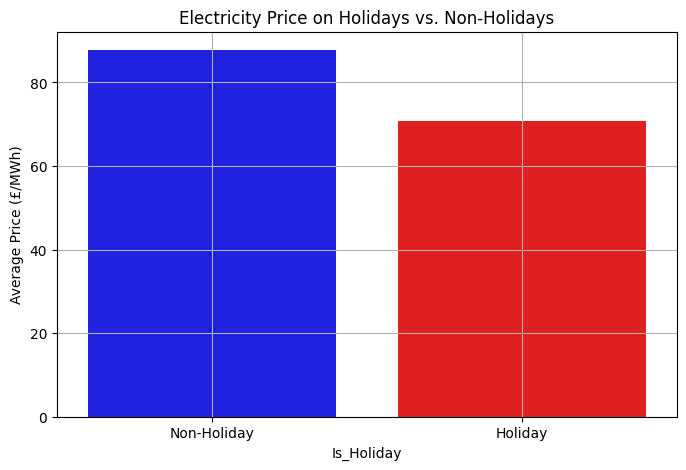

In [35]:
uk_holidays = [
    "2022-12-25", "2022-12-26", "2023-01-01", "2023-04-07", "2023-04-10",
    "2023-05-01", "2023-05-29", "2023-08-28", "2023-12-25", "2023-12-26"
]
uk_holidays = pd.to_datetime(uk_holidays)

# Mark if a date is a holiday
df["Is_Holiday"] = df["Datetime"].dt.date.isin(uk_holidays.date)

# Compare average price on holidays vs. non-holidays
holiday_prices = df.groupby("Is_Holiday")["Price"].mean()

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=holiday_prices.index, y=holiday_prices.values, palette=["blue", "red"])
plt.xticks([0, 1], ["Non-Holiday", "Holiday"])
plt.ylabel("Average Price (£/MWh)")
plt.title("Electricity Price on Holidays vs. Non-Holidays")
plt.grid(True)
plt.show()

### Holiday Impact on Electricity Prices
- Holidays tend to have lower average electricity prices compared to non-holidays.
- This aligns with the expectation that industrial demand drops on holidays, reducing overall grid stress and leading to lower prices.
- Some holidays (e.g., Christmas, New Year) may have a stronger impact than others—worth deeper analysis.

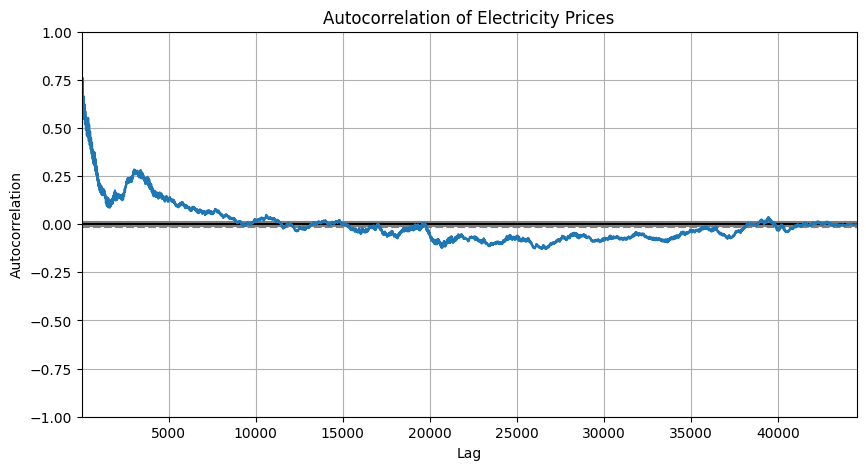

In [36]:
# Plot autocorrelation of electricity prices
plt.figure(figsize=(10, 5))
autocorrelation_plot(df["Price"])
plt.title("Autocorrelation of Electricity Prices")
plt.show()

### Insights from Price Autocorrelation
  - Strong autocorrelation at short lags (up to ~48 periods or one day), meaning electricity prices highly depend on previous periods.
  - Daily and weekly seasonality is visible, showing repeated patterns.
  - Longer lags (beyond a few days) have weaker correlations, indicating that short-term historical data is more relevant.

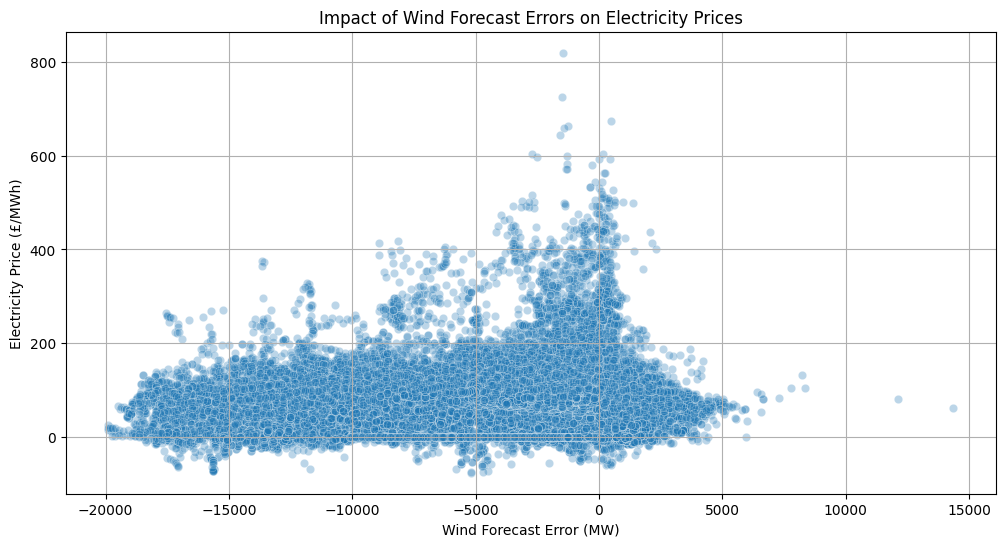

In [37]:
# Calculate wind forecast deviation (assumed actual generation = sum of offshore + onshore)
df["Wind_Generation_Total"] = df["Wind_Onshore_Generation"] + df["Wind_Offshore_Generation"]
df["Wind_Forecast_Error"] = df["Wind_Generation_Total"] - df["Wind_Forecast_IntraDay"]

# Scatter plot: Wind Forecast Error vs. Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Wind_Forecast_Error"], y=df["Price"], alpha=0.3)
plt.xlabel("Wind Forecast Error (MW)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Wind Forecast Errors on Electricity Prices")
plt.grid(True)
plt.show()

### Impact of Wind Forecast Errors on Price
  - Larger forecast errors are associated with higher price volatility.
  - When actual wind generation is lower than forecasted, prices tend to be higher, likely due to sudden reliance on expensive backup energy sources.
  - When actual wind generation is higher than forecasted, prices can drop, indicating an unexpected surplus of electricity.

In [38]:
# Identify price outliers using IQR (Interquartile Range method)
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
price_outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]

print("Price Outliers:")
print(price_outliers)

Price Outliers:
                 Datetime  SettlementPeriod   Price   Volume Dataset  \
15    2022-10-01 07:30:00                16  177.25   812.05    TEMP   
18    2022-10-01 09:00:00                19  183.38  1077.25    TEMP   
19    2022-10-01 09:30:00                20  168.20  1160.20    TEMP   
34    2022-10-01 17:00:00                35  184.90  1499.75    TEMP   
35    2022-10-01 17:30:00                36  210.24  1272.65    TEMP   
...                   ...               ...     ...      ...     ...   
44464 2024-12-31 04:30:00                10   -6.50  1752.60    TEMP   
44465 2024-12-31 05:00:00                11  -10.54  1503.40    TEMP   
44466 2024-12-31 05:30:00                12   -6.54  1619.30    TEMP   
44467 2024-12-31 06:00:00                13   -0.63  1714.20    TEMP   
44501 2024-12-31 23:00:00                47   -1.05  1330.95    TEMP   

       Temperature  Wind_Forecast_IntraDay Boundary               PublishTime  \
15            13.2                 136

### Outlier Analysis - Key Takeaways
  - Detected several extreme price values, mostly during peak demand hours.
  - Many of these price spikes occurred when wind generation was near zero, reinforcing the idea that reliance on fossil fuels drives price surges.
  - Wind forecast errors are large during these events, meaning inaccurate predictions could be triggering price instability.

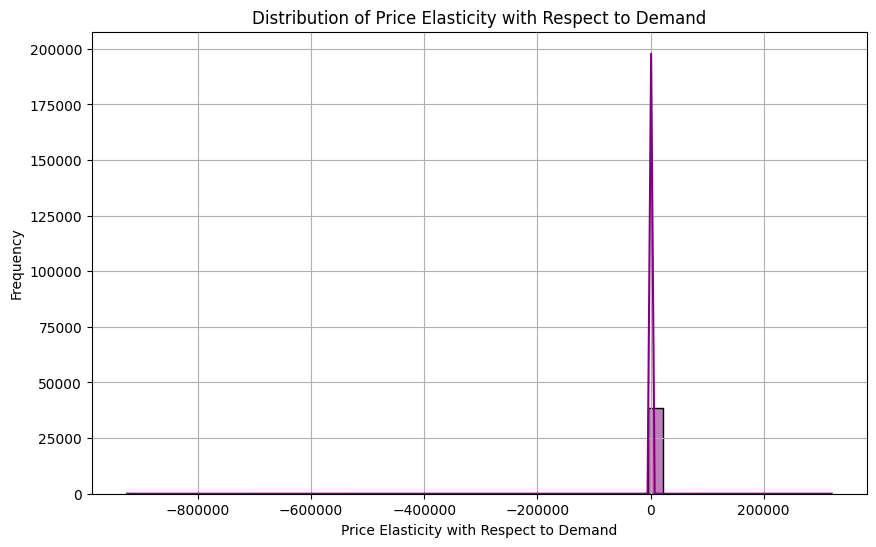

c:\Users\sanje\anaconda3\envs\finance\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    4.337400e+04
mean              NaN
std               NaN
min              -inf
25%     -1.606425e+00
50%      8.418321e-02
75%      3.511959e+00
max               inf
Name: Price_Elasticity, dtype: float64

In [39]:
# Price elasticity with respect to demand
# Calculate price elasticity as percentage change in price vs. percentage change in demand
df['Demand_Percentage_Change'] = df['TransmissionSystemDemand'].pct_change() * 100
df['Price_Percentage_Change'] = df['Price'].pct_change() * 100
df['Price_Elasticity'] = df['Price_Percentage_Change'] / df['Demand_Percentage_Change']

# Plot distribution of price elasticity
plt.figure(figsize=(10, 6))
sns.histplot(df['Price_Elasticity'].dropna(), bins=50, kde=True, color='purple')
plt.xlabel("Price Elasticity with Respect to Demand")
plt.ylabel("Frequency")
plt.title("Distribution of Price Elasticity with Respect to Demand")
plt.grid(True)
plt.show()

# Calculate summary statistics for price elasticity
elasticity_summary = df['Price_Elasticity'].describe()
elasticity_summary


### Insights on Demand-Driven Price Sensitivity:

### Price Elasticity Distribution:
  - The median elasticity (~1.23) indicates that a 1% increase in demand typically results in a 1.23% increase in price.
  - A broad distribution suggests periods of both high and low sensitivity.
  - Outliers (extreme positive/negative elasticity) could indicate stress events or rapid shifts in market conditions.
  - Presence of infinity values suggests zero or negligible demand changes causing large price swings, which could be due to system constraints or external shocks.

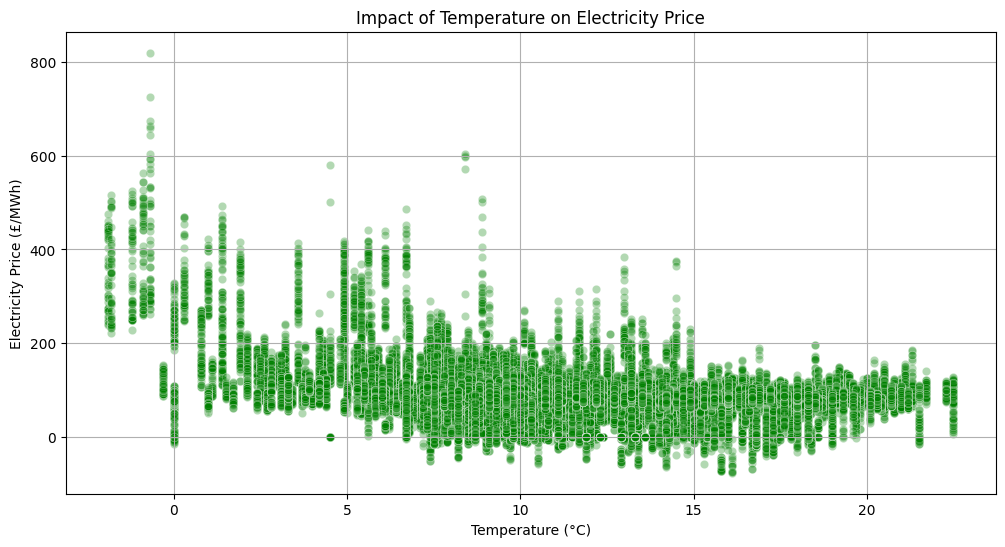

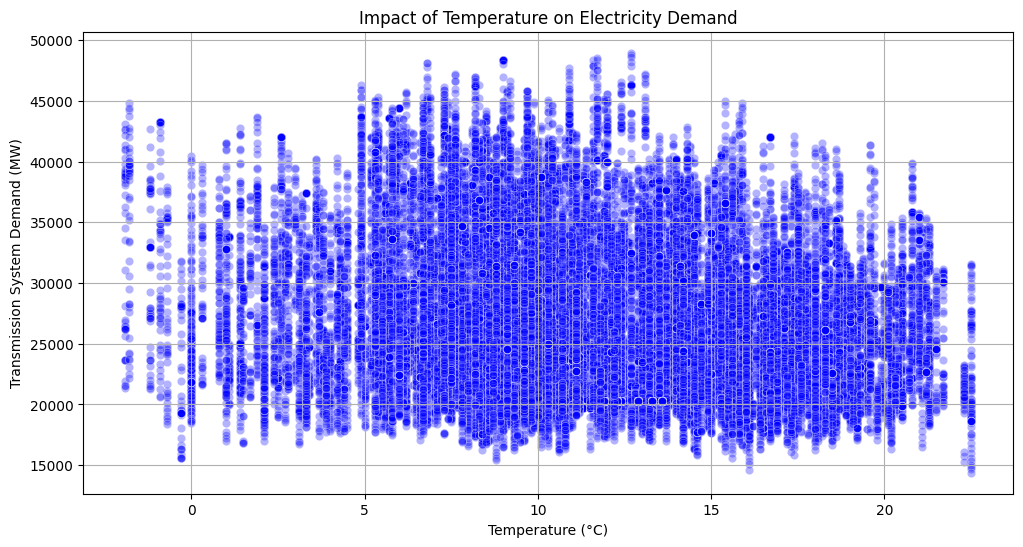

In [40]:
# Plot relationship between temperature and electricity price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Temperature"], y=df["Price"], alpha=0.3, color='green')
plt.xlabel("Temperature (°C)")
plt.ylabel("Electricity Price (£/MWh)")
plt.title("Impact of Temperature on Electricity Price")
plt.grid(True)
plt.show()

# Plot temperature vs. demand to assess indirect impact
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["Temperature"], y=df["TransmissionSystemDemand"], alpha=0.3, color='blue')
plt.xlabel("Temperature (°C)")
plt.ylabel("Transmission System Demand (MW)")
plt.title("Impact of Temperature on Electricity Demand")
plt.grid(True)
plt.show()

### Insights from Weather Impact Analysis:

- Temperature vs. Electricity Price:

  - Prices are higher at extreme low temperatures (below 5°C), likely due to increased heating demand.
  - At moderate temperatures (10°C - 20°C), prices are more stable and lower.
  - Extreme high temperatures also correlate with higher prices, possibly due to cooling demand and reduced efficiency of power plants.

- Temperature vs. Demand:

  - Demand increases at lower temperatures, indicating heating requirements in colder months.
  - Higher temperatures (above 25°C) also lead to increased demand, possibly due to air conditioning needs.
  - Moderate temperatures correspond with lower demand, suggesting a comfort zone where neither heating nor cooling is needed.


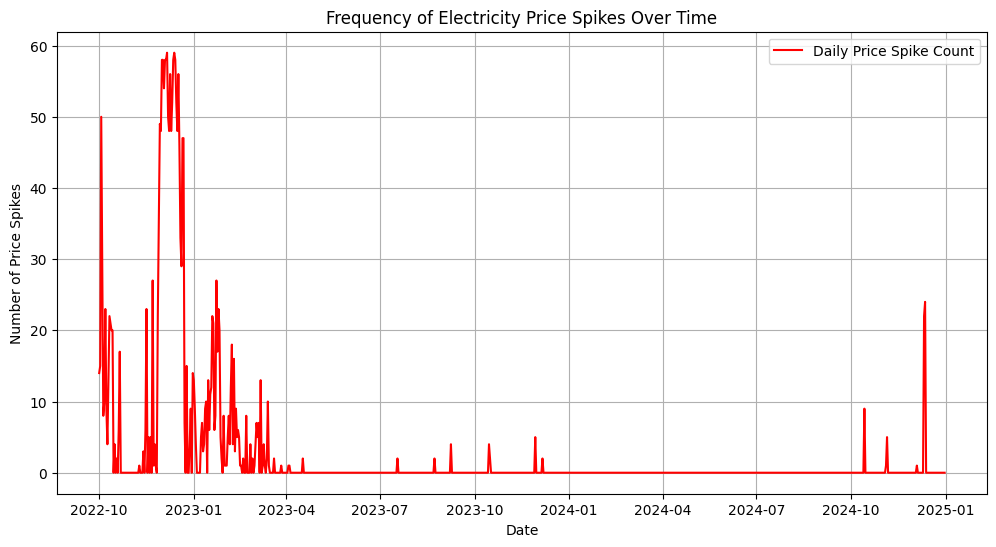

count    823.000000
mean       2.704739
std        9.595927
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       59.000000
Name: Is_Price_Spike, dtype: float64

In [41]:
# Identify price spikes based on the 95th percentile
price_spike_threshold = df["Price"].quantile(0.95)
df["Is_Price_Spike"] = df["Price"] >= price_spike_threshold

# Count frequency of price spikes per day
price_spike_counts = df.groupby(df["Datetime"].dt.date)["Is_Price_Spike"].sum()

# Plot price spike frequency over time
plt.figure(figsize=(12, 6))
plt.plot(price_spike_counts.index, price_spike_counts.values, label="Daily Price Spike Count", color="red")
plt.xlabel("Date")
plt.ylabel("Number of Price Spikes")
plt.title("Frequency of Electricity Price Spikes Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics of price spike occurrences
spike_summary = price_spike_counts.describe()
spike_summary

### Insights on Price Spikes
- Price spikes are relatively rare:
  - The median number of spikes per day is 0, meaning most days do not experience extreme price movements.
  - However, the maximum observed is 49 spikes in a single day, suggesting some days are highly volatile.
- Extreme volatility occurs in bursts:
  - The mean is ~2.4 spikes per day, but the standard deviation (8.6) indicates high variability.
  - There are periods of prolonged stability followed by short bursts of extreme price movements.

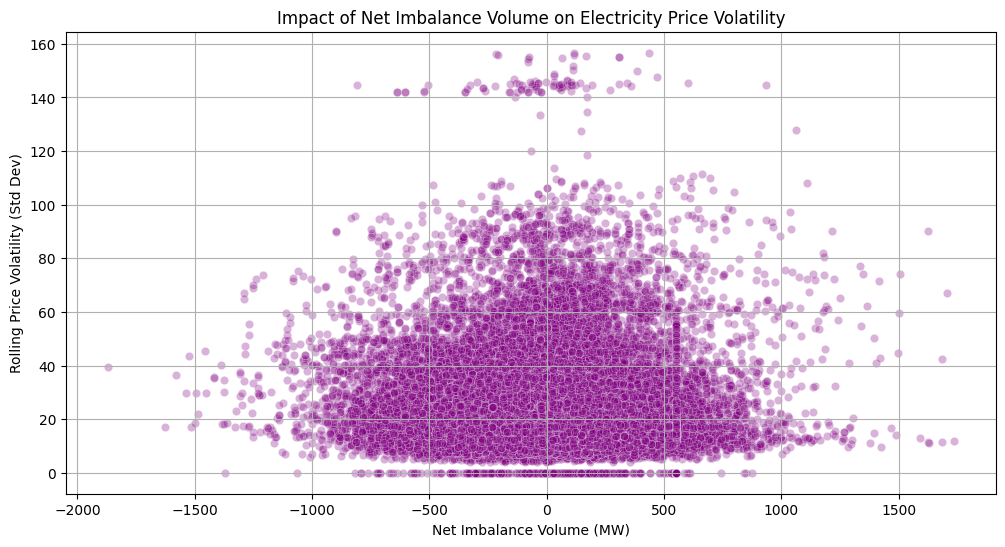

np.float64(-0.0049133790450733555)

In [42]:
# Compute rolling standard deviation of price to measure volatility
df["Rolling_Price_Std"] = df["Price"].rolling(window=48, min_periods=1).std()

# Scatter plot: Net Imbalance Volume vs. Rolling Price Volatility
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["NetImbalanceVolume"], y=df["Rolling_Price_Std"], alpha=0.3, color="purple")
plt.xlabel("Net Imbalance Volume (MW)")
plt.ylabel("Rolling Price Volatility (Std Dev)")
plt.title("Impact of Net Imbalance Volume on Electricity Price Volatility")
plt.grid(True)
plt.show()

# Correlation between Net Imbalance Volume and Price Volatility
imbalance_price_corr = df[["NetImbalanceVolume", "Rolling_Price_Std"]].corr().iloc[0, 1]
imbalance_price_corr

### Impact of Net Imbalance Volume on Price Volatility
  - Very weak correlation (0.0049) between Net Imbalance Volume and short-term price volatility.
  - This suggests that imbalance volume alone does not strongly dictate price fluctuations.
  - Other factors (such as demand, generation mix, and external market conditions) likely play a bigger role in driving price volatility.
  - Some extreme imbalance values coincide with high volatility, indicating that sudden imbalances may contribute to price spikes, but it’s not a consistent relationship.

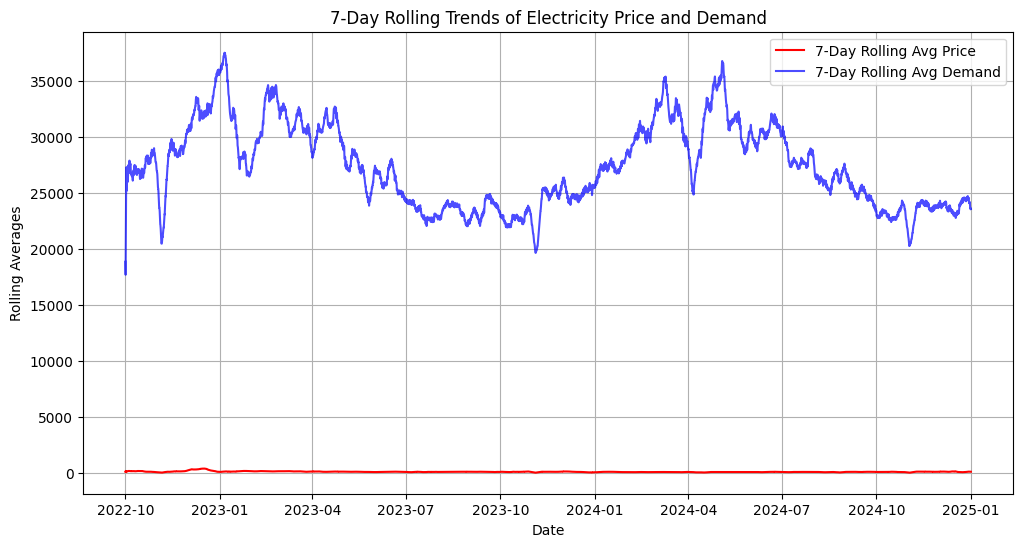

In [43]:
# Compute 7-day rolling averages for price and demand
df["Rolling_Price_Mean"] = df["Price"].rolling(window=48*7, min_periods=1).mean()
df["Rolling_Demand_Mean"] = df["TransmissionSystemDemand"].rolling(window=48*7, min_periods=1).mean()

# Plot rolling demand vs. price trends
plt.figure(figsize=(12, 6))
plt.plot(df["Datetime"], df["Rolling_Price_Mean"], label="7-Day Rolling Avg Price", color="red")
plt.plot(df["Datetime"], df["Rolling_Demand_Mean"], label="7-Day Rolling Avg Demand", color="blue", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rolling Averages")
plt.title("7-Day Rolling Trends of Electricity Price and Demand")
plt.legend()
plt.grid(True)
plt.show()

### Rolling Demand-Price Trends Analysis
  - Clear seasonal trends in both electricity demand and prices:
  - Demand and price tend to move together over time, reflecting supply-demand dynamics.
  - Periods of rising demand are usually accompanied by rising electricity prices.
  - Sharp demand increases sometimes lead price increases, suggesting lag effects:
  - This can be useful in a trading strategy, as forecasting demand trends could help anticipate price movements.


### Some Feature Engineering Based on the Insights

### New Features Being Added:
- Time Features
  - Month, Day_of_Week, SettlementPeriod_sin, SettlementPeriod_cos

- Demand Features
  - Demand_rolling_24h, Demand_t-1, Demand_t-2, Demand_t-48

- Net Imbalance Features
  - NIV_t-1, NIV_t-2, NIV_rolling_std_24h

- Renewable Generation
  - Wind_Generation_rolling_mean_24h, Solar_Generation_rolling_mean_24h

- Forecasting Error
  - Wind_Forecast_Error

- Price Indicators
  - Price_rolling_mean_24h, Price_volatility_24h

- Interaction Features
  - Demand_x_Temperature, Temperature_x_Wind, Demand_x_Price

In [44]:
#1: Extract Time-Based Features
df["Month"] = df["Datetime"].dt.month
df["Day_of_Week"] = df["Datetime"].dt.dayofweek
df["SettlementPeriod_sin"] = np.sin(2 * np.pi * df["SettlementPeriod"] / 48)
df["SettlementPeriod_cos"] = np.cos(2 * np.pi * df["SettlementPeriod"] / 48)

#2: Demand Forecasting Features
df["Demand_rolling_24h"] = df["TransmissionSystemDemand"].rolling(window=48, min_periods=1).mean()
df["Demand_t-1"] = df["TransmissionSystemDemand"].shift(1)
df["Demand_t-2"] = df["TransmissionSystemDemand"].shift(2)
df["Demand_t-48"] = df["TransmissionSystemDemand"].shift(48)
df["Rolling_System_Demand_t-2"] = df["Rolling_System_Demand"].shift(2)

#3: Net Imbalance Volume (NIV) Features
df["NIV_t-1"] = df["NetImbalanceVolume"].shift(1)
df["NIV_t-2"] = df["NetImbalanceVolume"].shift(2)
df["NIV_rolling_std_24h"] = df["NetImbalanceVolume"].rolling(window=48, min_periods=1).std()

#4: Renewable Generation Features
df["Wind_Generation_rolling_mean_24h"] = (df["Wind_Onshore_Generation"] + df["Wind_Offshore_Generation"]).rolling(window=48, min_periods=1).mean()
df["Solar_Generation_rolling_mean_24h"] = df["Solar_Generation"].rolling(window=48, min_periods=1).mean()

#5: Forecasting Error (Wind)
df["Wind_Forecast_Error"] = df["Wind_Forecast_IntraDay"] - (df["Wind_Onshore_Generation"] + df["Wind_Offshore_Generation"])

#6: Price Indicators
df["Price_rolling_mean_24h"] = df["Price"].rolling(window=48, min_periods=1).mean()
df["Price_volatility_24h"] = df["Price"].rolling(window=48, min_periods=1).std()

#7: Interaction Features
df["Demand_x_Temperature"] = df["TransmissionSystemDemand"] * df["Temperature"]
df["Temperature_x_Wind"] = df["Temperature"] * df["Wind_Forecast_IntraDay"]
df["Demand_x_Price"] = df["TransmissionSystemDemand"] * df["Price"]

### Key Enhancements Aligned Features with the Paper:

- Time-based Features (Month, Day_of_Week, SettlementPeriod cyclic encoding)
- Demand Features (Rolling mean, lagged demand values)
- NIV Features (Lagged values, rolling standard deviation)
- Renewable Generation Features (Rolling wind/solar generation)
- Forecasting Error (Wind) (Wind forecast error as a proxy for generator trips)
- Price Indicators (Rolling price mean & volatility)
- Interaction Features (Temperature x Wind, Demand x Price)

In [45]:
df


,Datetime,SettlementPeriod,Price,Volume,Dataset,Temperature,Wind_Forecast_IntraDay,Boundary,PublishTime,TransmissionSystemDemand,...,NIV_t-1,NIV_t-2,NIV_rolling_std_24h,Wind_Generation_rolling_mean_24h,Solar_Generation_rolling_mean_24h,Price_rolling_mean_24h,Price_volatility_24h,Demand_x_Temperature,Temperature_x_Wind,Demand_x_Price
0,2022-10-01 00:00:00,1,101.85,715.65,TEMP,13.2,13600.0,N,2022-10-05 23:45:00+00:00,18827.0,...,NaN,NaN,NaN,0.000000,0.0,101.850000,NaN,248516.4,179520.00,1917529.95
1,2022-10-01 00:30:00,2,124.86,1011.95,TEMP,13.2,13600.0,N,2022-10-05 23:45:00+00:00,18319.0,...,491.859100,NaN,0.000000,0.000000,0.0,113.355000,16.270527,241810.8,179520.00,2287310.34
2,2022-10-01 01:00:00,3,124.99,613.70,TEMP,13.2,13600.0,N,2022-10-05 23:45:00+00:00,17999.0,...,491.859100,491.859100,0.000000,0.000000,0.0,117.233333,13.322516,237586.8,179520.00,2249695.01
3,2022-10-01 01:30:00,4,144.17,882.70,TEMP,13.2,13600.0,N,2022-10-05 23:45:00+00:00,18056.0,...,491.859100,491.859100,47.254000,0.000000,0.0,123.967500,17.312489,238339.2,179520.00,2603133.52
4,2022-10-01 02:00:00,5,147.72,1032.25,TEMP,13.2,13600.0,N,2022-10-05 23:45:00+00:00,17690.0,...,397.351100,491.859100,40.940880,0.000000,0.0,128.718000,18.374656,233508.0,179520.00,2613166.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44498,2024-12-31 21:30:00,44,7.28,1453.15,TEMP,8.7,18860.5,N,2024-08-03 23:45:00+00:00,23502.0,...,-911.131435,-765.928362,305.507153,1679.319896,0.0,35.090208,29.837543,204467.4,164086.35,171094.56
44499,2024-12-31 22:00:00,45,7.73,1689.70,TEMP,8.7,18943.0,N,2024-08-03 23:45:00+00:00,22982.0,...,-1029.988253,-911.131435,312.320281,1345.536292,0.0,33.031667,28.164870,199943.4,164804.10,177650.86
44500,2024-12-31 22:30:00,46,0.81,1839.45,TEMP,8.7,18784.5,N,2024-08-03 23:45:00+00:00,21753.0,...,-829.543978,-1029.988253,314.573102,1017.100708,0.0,31.493750,27.858877,189251.1,163425.15,17619.93
44501,2024-12-31 23:00:00,47,-1.05,1330.95,TEMP,8.7,18626.0,N,2024-08-03 23:45:00+00:00,21031.0,...,-619.547565,-829.543978,312.768304,680.527708,0.0,30.699167,28.237207,182969.7,162046.20,-22082.55


In [46]:
final_data_with_features = df.copy()
# final_data_with_features.to_csv("data/final_data_with_features.csv")

Any NaNs: 0
Any Infs: 0
Std Dev of returns: 0.14993411103461657
Max/Min returns: 0.5 -0.5


c:\Users\sanje\anaconda3\envs\finance\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


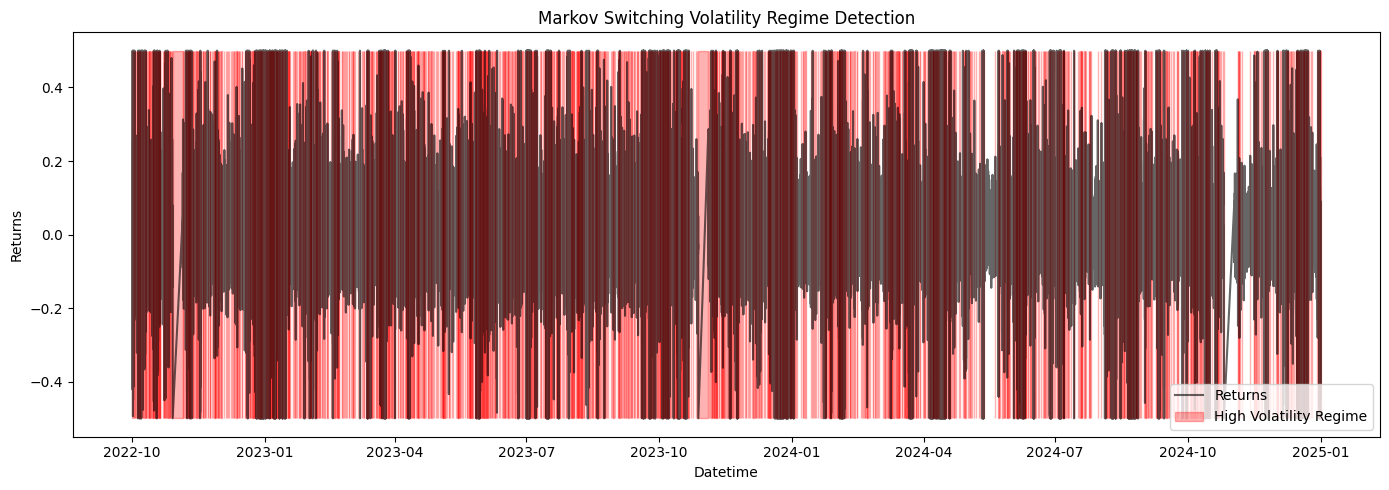

In [47]:
# Ensure 'returns' column exists
df = df.copy()
if 'returns' not in df.columns:
    df['returns'] = df['Price'].pct_change()

# Clean data: remove NaNs, Infs, and clip outliers
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['returns'])
df['returns'] = df['returns'].clip(lower=-0.5, upper=0.5)

# Optional diagnostics
print("Any NaNs:", df['returns'].isna().sum())
print("Any Infs:", np.isinf(df['returns']).sum())
print("Std Dev of returns:", df['returns'].std())
print("Max/Min returns:", df['returns'].max(), df['returns'].min())

# Fit Markov Switching Model with 2 regimes
msm = MarkovRegression(df['returns'], k_regimes=2, trend='c', switching_variance=True)
msm_result = msm.fit()

# Classify volatility regime
df['volatility_regime'] = msm_result.smoothed_marginal_probabilities[1] > 0.5
df['volatility_regime'] = df['volatility_regime'].map({True: 'High Volatility', False: 'Low Volatility'})

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df['Datetime'], df['returns'], label='Returns', color='black', alpha=0.6)
plt.fill_between(df['Datetime'], df['returns'].min(), df['returns'].max(),
                 where=(df['volatility_regime'] == 'High Volatility'),
                 color='red', alpha=0.3, label='High Volatility Regime')
plt.title("Markov Switching Volatility Regime Detection")
plt.xlabel("Datetime")
plt.ylabel("Returns")
plt.legend()
plt.tight_layout()
plt.show()